In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [2]:
df = pd.read_csv('housing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [4]:
df = df.drop(columns='ocean_proximity')

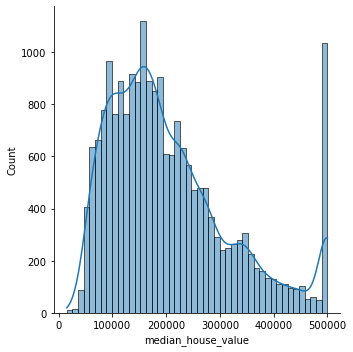

In [5]:
sns.displot(df, x="median_house_value", kde=True)

In [6]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [7]:
df.population.median()

1166.0

In [8]:
df_len = len(df)
df_idx = np.arange(df_len)
np.random.shuffle(df_idx)

train_len = int(df_len * 0.6)
val_len = int(df_len * 0.2)
test_len = df_len - (train_len + val_len)

print(f"Len of train: {train_len}")
print(f"Len of validate: {val_len}")
print(f"Len of test: {test_len}")

df_train = df.iloc[df_idx[:train_len]]
df_val = df.iloc[df_idx[train_len:train_len + val_len]]
df_test = df.iloc[df_idx[train_len + val_len:]]

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

df_train = df_train.drop(columns='median_house_value')
df_val = df_val.drop(columns='median_house_value')
df_test = df_test.drop(columns='median_house_value')

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

Len of train: 12384
Len of validate: 4128
Len of test: 4128


In [9]:
def train_linear_regression(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def predict_linear_regression(w_0, w, X):
    return w_0 + X.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [10]:
df_train_zero_filled = df_train.copy()
df_val_zero_filled = df_val.copy()
df_test_zero_filled = df_test.copy()

df_train_zero_filled = df_train_zero_filled.fillna(0)
df_val_zero_filled = df_val_zero_filled.fillna(0)
df_test_zero_filled = df_test_zero_filled.fillna(0)

w_0_zero_filled, w_zero_filled = train_linear_regression(df_train_zero_filled.values, y_train)
y_pred_zero_filled = w_0_zero_filled + df_train_zero_filled.dot(w_zero_filled)

y_pred_val_zero_filled = w_0_zero_filled + df_val_zero_filled.dot(w_zero_filled)
print(f"RMSE for zero filled validation dataset: {round(rmse(y_val, y_pred_val_zero_filled), 2)}")

RMSE for zero filled validation dataset: 0.33


In [11]:
df_train_mean_filled = df_train.copy()
df_val_mean_filled = df_val.copy()
df_test_mean_filled = df_test.copy()

mean_value = df_train_mean_filled.total_bedrooms.mean()

df_train_mean_filled.total_bedrooms = df_train_mean_filled.total_bedrooms.fillna(mean_value)
df_val_mean_filled.total_bedrooms = df_val_mean_filled.total_bedrooms.fillna(mean_value)
df_test_mean_filled.total_bedrooms = df_test_mean_filled.total_bedrooms.fillna(mean_value)

w_0_mean_filled, w_mean_filled = train_linear_regression(df_train_mean_filled.values, y_train)
y_pred_mean_filled = w_0_mean_filled + df_train_mean_filled.dot(w_mean_filled)

y_pred_val_mean_filled = w_0_mean_filled + df_val_mean_filled.dot(w_mean_filled)
print(f"RMSE for mean filled validation dataset: {round(rmse(y_val, y_pred_val_mean_filled), 2)}")

RMSE for mean filled validation dataset: 0.33


In [12]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression(df_train_zero_filled, y_train, r)
    y_val_pred = predict_linear_regression(w_0, w, df_val_zero_filled)
    score = round(rmse(y_val, y_val_pred), 2)
    print(f'r = {r}; score = {score}')

r = 0; score = 0.33
r = 1e-06; score = 0.33
r = 0.0001; score = 0.33
r = 0.001; score = 0.33
r = 0.01; score = 0.33
r = 0.1; score = 0.33
r = 1; score = 0.33
r = 5; score = 0.34
r = 10; score = 0.34


In [13]:
train_len = int(df_len * 0.6)
val_len = int(df_len * 0.2)
test_len = df_len - (train_len + val_len)
df_len = len(df)

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

scores = []
for i, seed in enumerate(seeds):
    np.random.seed(seed)

    df_idx = np.arange(df_len)
    np.random.shuffle(df_idx)

    df_train = df.iloc[df_idx[:train_len]]
    df_val = df.iloc[df_idx[train_len:train_len + val_len]]

    y_train = df_train.median_house_value.values
    y_val = df_val.median_house_value.values

    X_train = df_train.drop(columns='median_house_value').fillna(0)
    X_val = df_val.drop(columns='median_house_value').fillna(0)

    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    w_0, w = train_linear_regression(X_train, y_train)
    y_val_pred = predict_linear_regression(w_0, w, X_val)
    score = rmse(y_val, y_val_pred)
    scores.append(score)
print(scores)
print(round(np.std(scores), 3))

[0.3388430480529002, 0.3362387255957136, 0.33209123188428413, 0.3405153609042384, 0.33890240665725224, 0.3434866725718318, 0.34519809530989204, 0.33959899274077954, 0.34662308731908026, 0.33659261241731864]
0.004


In [14]:

np.random.seed(9)

df_idx = np.arange(df_len)
np.random.shuffle(df_idx)

df_train = df.iloc[df_idx[:train_len]]
df_val = df.iloc[df_idx[train_len:train_len + val_len]]
df_test = df.iloc[df_idx[train_len + val_len:]]

df_train = pd.concat([df_train, df_val])

y_train = df_train.median_house_value.values
y_test = df_test.median_house_value.values

X_train = df_train.drop(columns='median_house_value').fillna(0)
X_test = df_test.drop(columns='median_house_value').fillna(0)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

w_0, w = train_linear_regression(X_train, y_train, r=0.001)
y_test_pred = predict_linear_regression(w_0, w, X_test)
round(rmse(y_test, y_test_pred), 2)

0.35